In [1]:
# Now to check out how we can run a survey that uses a Markov Decision Process to generate pointings

In [2]:
from rubin_sim.scheduler.utils import SkyAreaGenerator, Footprint, make_rolling_footprints
from rubin_sim.scheduler.model_observatory import ModelObservatory

import healpy as hp
%matplotlib inline
import numpy as np

import rubin_sim.scheduler.basis_functions as bf
from rubin_sim.scheduler.surveys import BlobSurvey
from rubin_sim.scheduler.schedulers import CoreScheduler
from rubin_sim.scheduler import sim_runner

from rubin_sim.scheduler.basis_functions import BaseBasisFunction

import matplotlib.pylab as plt

## Footprints ##

First up, we want to define a large area footprint. Here's how we do it for the baseline. The end result is a dict of HEALpix maps, with filternames for keys

In [3]:
sag = SkyAreaGenerator()
sky_maps, labels = sag.return_maps()

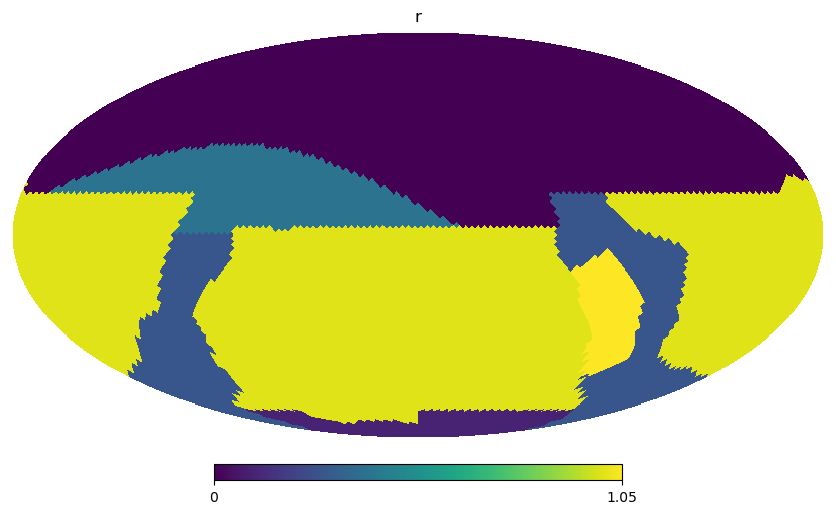

In [4]:
hp.mollview(sky_maps['r'], title='r')

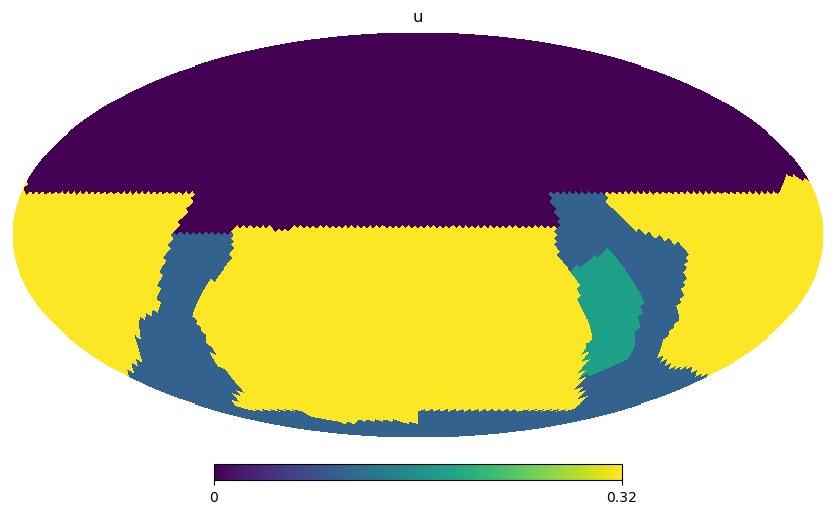

In [5]:
hp.mollview(sky_maps['u'], title='u')

In [6]:
# XXX--discuss the units on here. This is "relative count".

0 
1 LMC_SMC
2 bulge
3 dusty_plane
4 lowdust
5 nes
6 scp
7 virgo


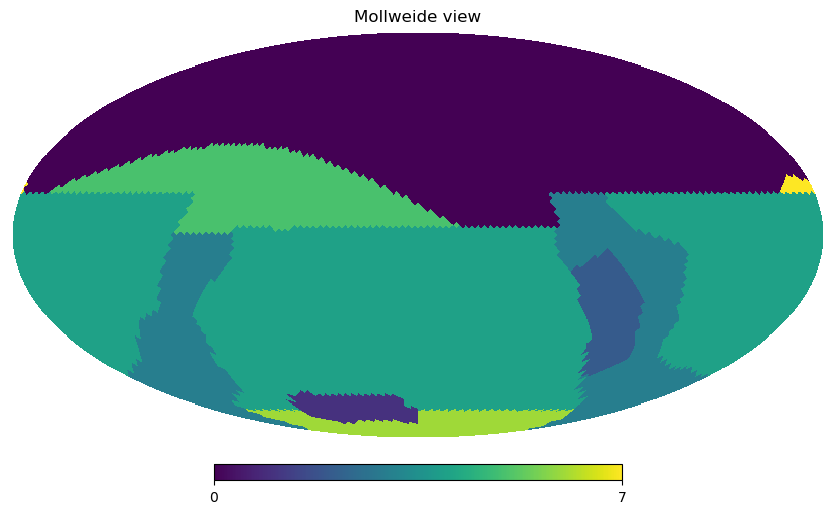

In [7]:
# Look at the labels
label_int = np.zeros(hp.nside2npix(32))
for i,label in enumerate(np.unique(labels)):
    indx = np.where(labels == label)[0]
    label_int[indx] = i
    print(i, label)
hp.mollview(label_int)


The sky maps above are what we want the footprint coverage to look like at the end of the survey. When scheduling observations, we need to take into account that different parts of the sky have been visible for different amounts of time. To do that, we have created the `Footprint` object

In [8]:
# How to make a footprint object

# We need the start date of the survey, so let's load up our model observatory and get that from the conditions
nside=32  # Specify the HEALpix resolution we want to do everything in.
mo = ModelObservatory(nside=nside)
conditions = mo.return_conditions()



In [9]:
# Instatiate our Footprint object, and set each filter
fp = Footprint(conditions.mjd_start, conditions.sun_ra_start)
for filtername in 'ugrizy':
    fp.set_footprint(filtername, sky_maps[filtername])

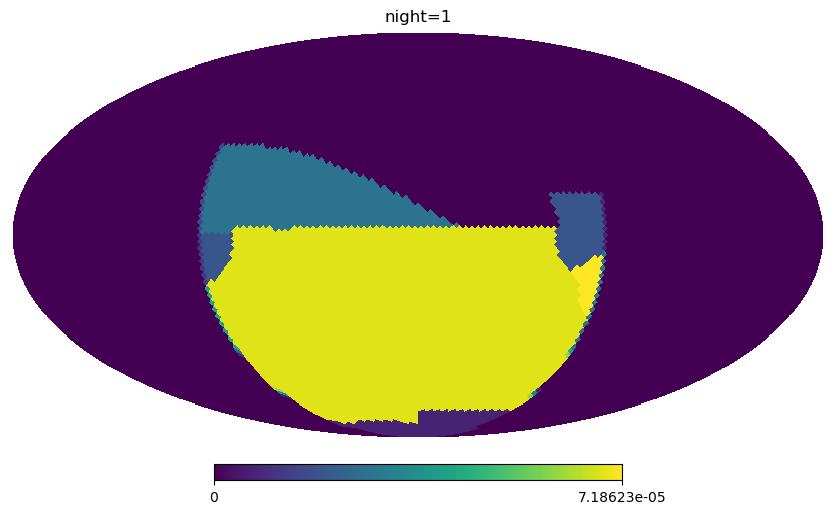

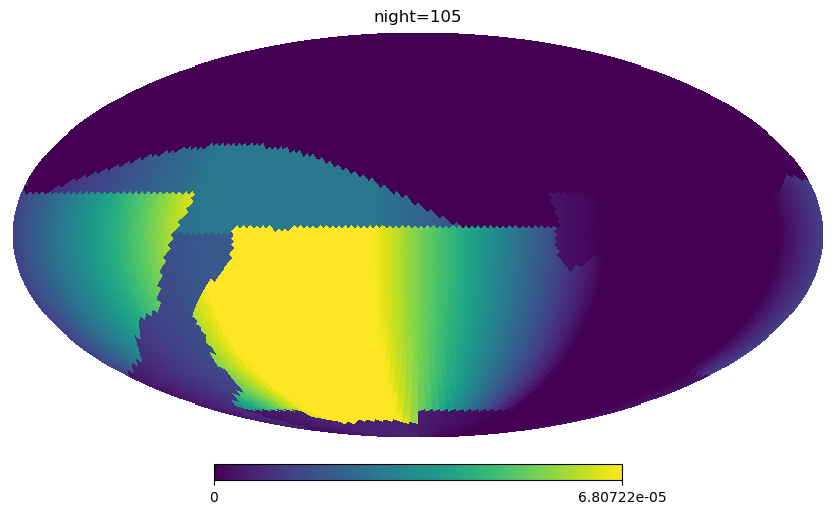

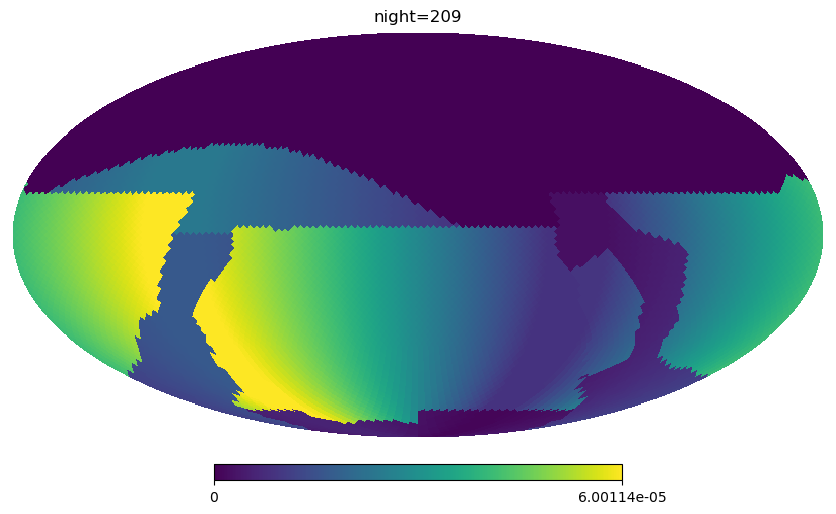

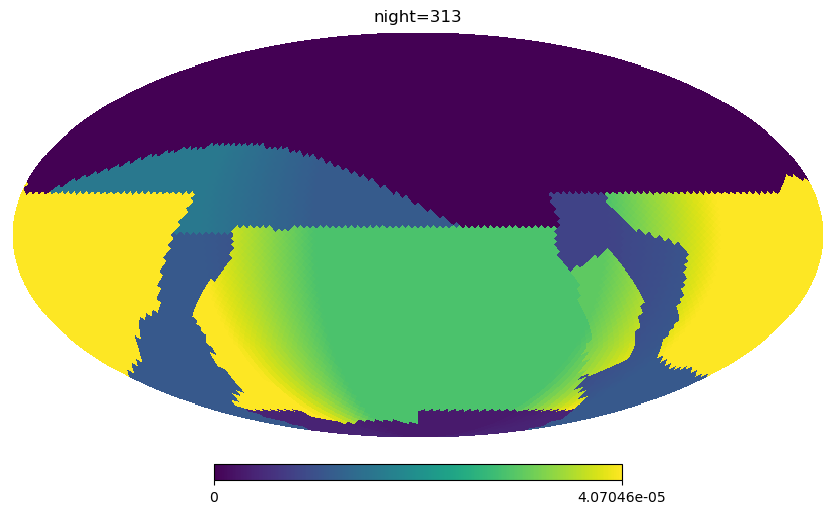

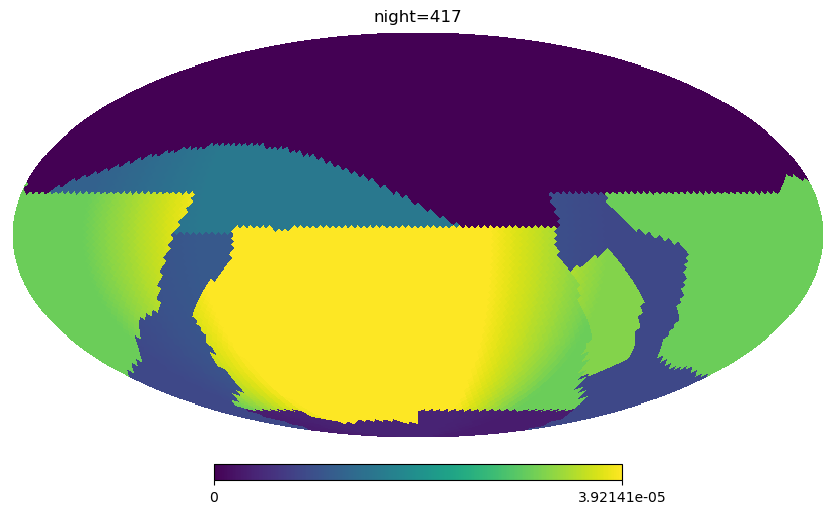

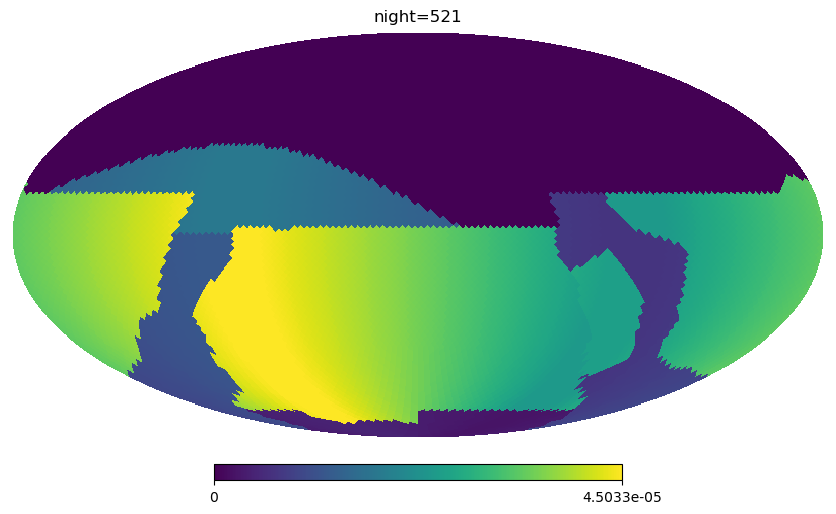

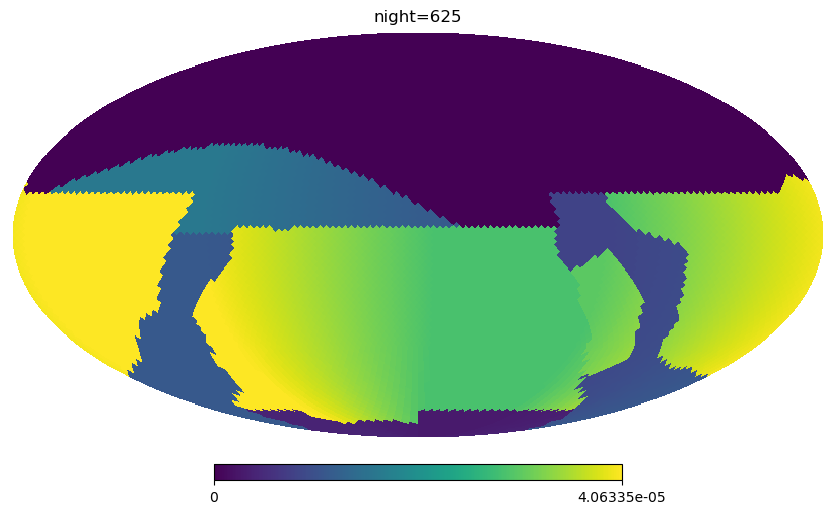

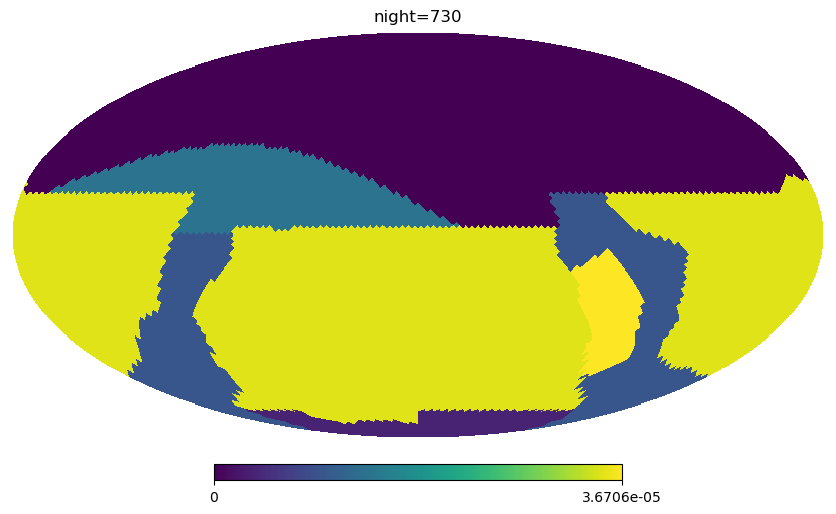

In [10]:
# The footprint object now scales our footprint properly by how long
# different parts of the sky have been visible.
mjds = np.linspace(1,365*2, 8) + conditions.mjd_start

for mjd in mjds:
    fp_at_mjd = fp(mjd)
    hp.mollview(fp_at_mjd['r'], title='night=%i' % (mjd-conditions.mjd_start))

In [11]:
# The default behavior is to have a constant cadence when a HEALpix is in season. 
# A Footprint object can be configured to have different evolution with time. This is how we do rolling cadence

# Which HEALpix we want to roll
rolling_indx = np.where((labels == 'lowdust') | (labels == 'LMC_SMC') | (labels == 'virgo'))[0]
# How many rolling slices to make
nslice = 2 
# How strong to make the rolling
scale = 0.9
# Need a dict rather than an array
footprints_hp = {}
for key in sky_maps.dtype.names:
    footprints_hp[key] = sky_maps[key]

# Helpful function for making rolling footprint objects
fp = make_rolling_footprints(fp_hp=footprints_hp, mjd_start=conditions.mjd_start,
                             sun_ra_start=conditions.sun_ra_start, nslice=nslice, scale=scale,
                             nside=nside, wfd_indx=rolling_indx)

For lots of details on how rolling cadence works, see:  https://pstn-052.lsst.io/

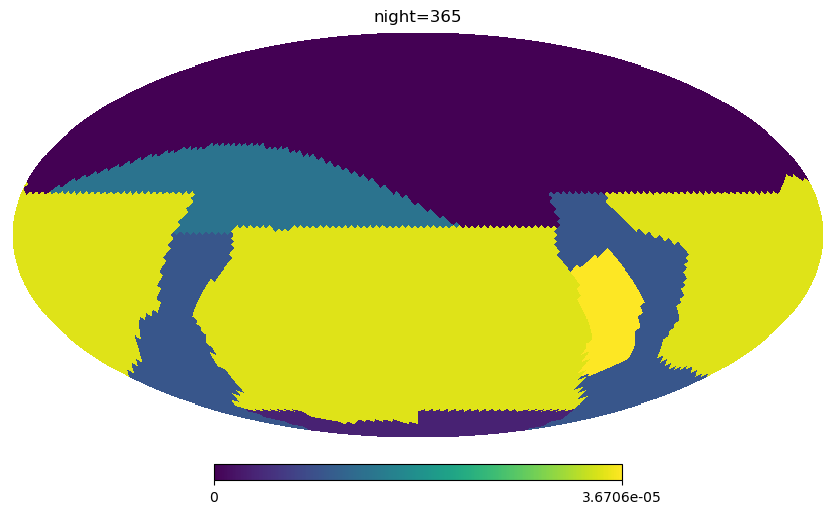

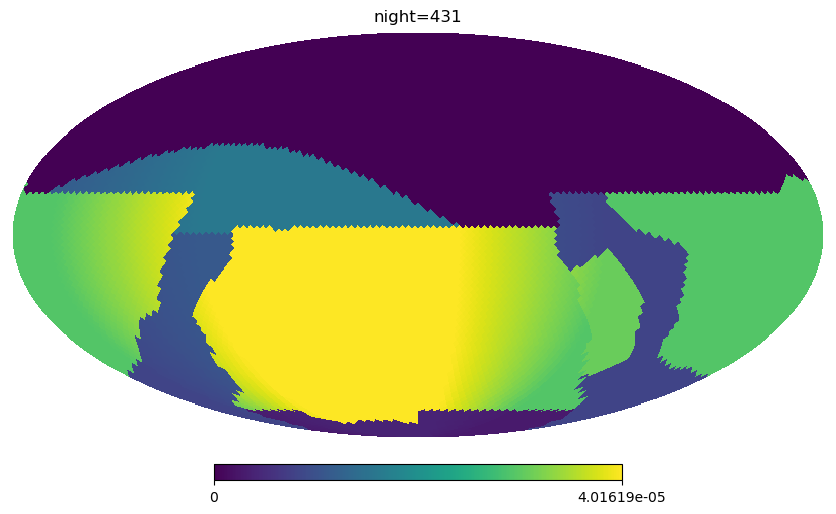

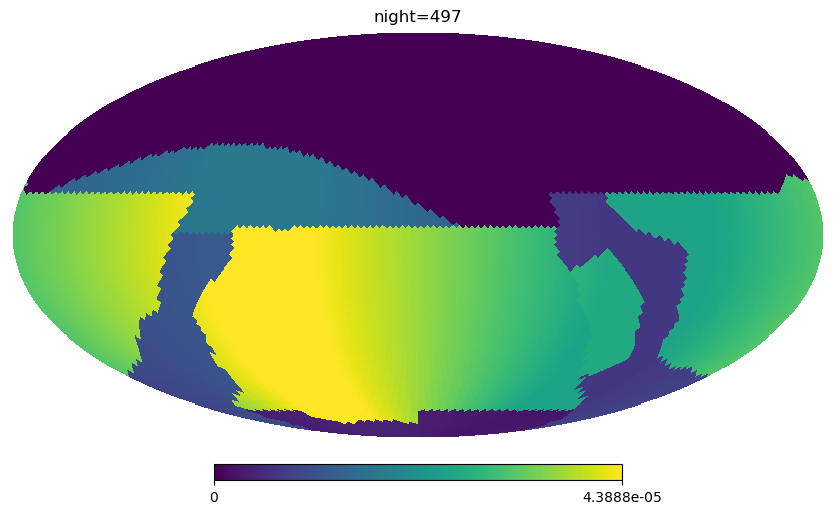

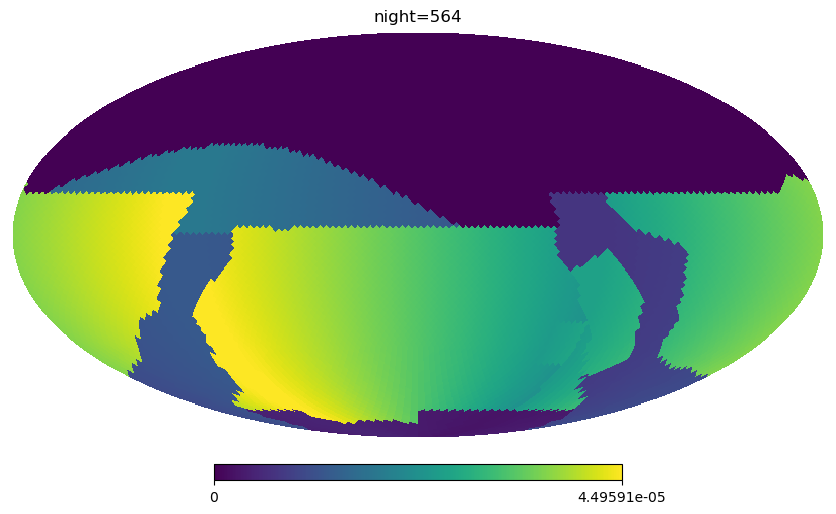

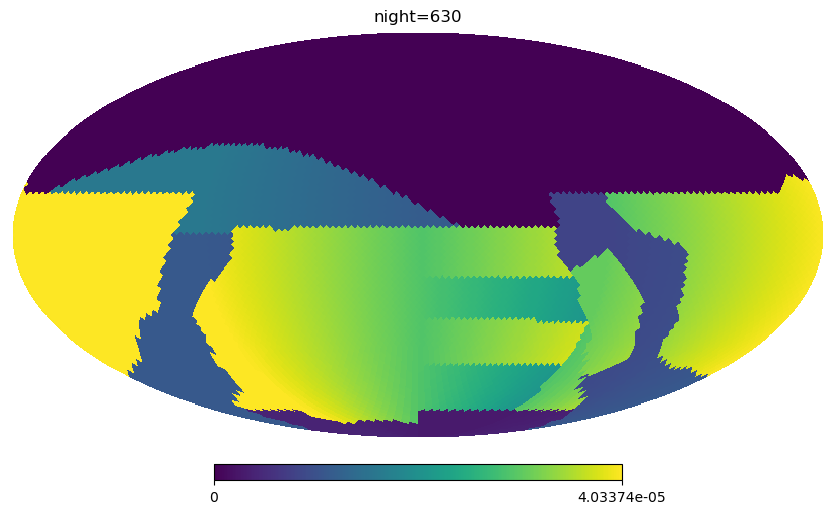

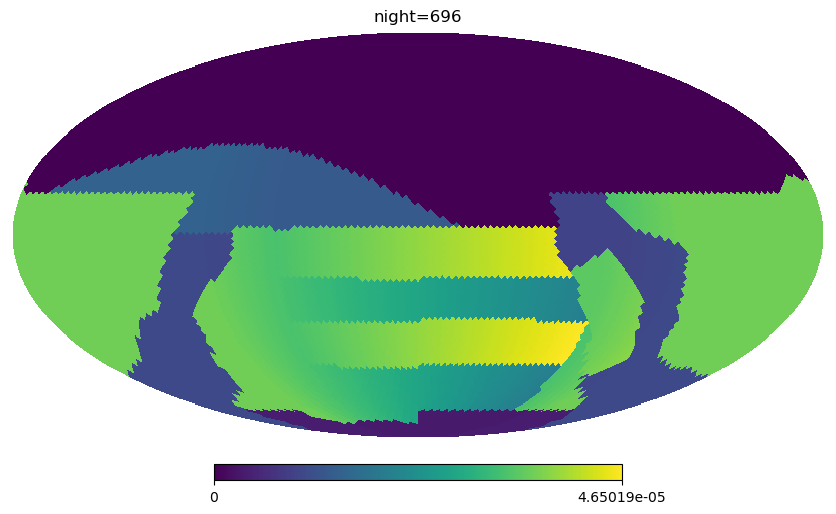

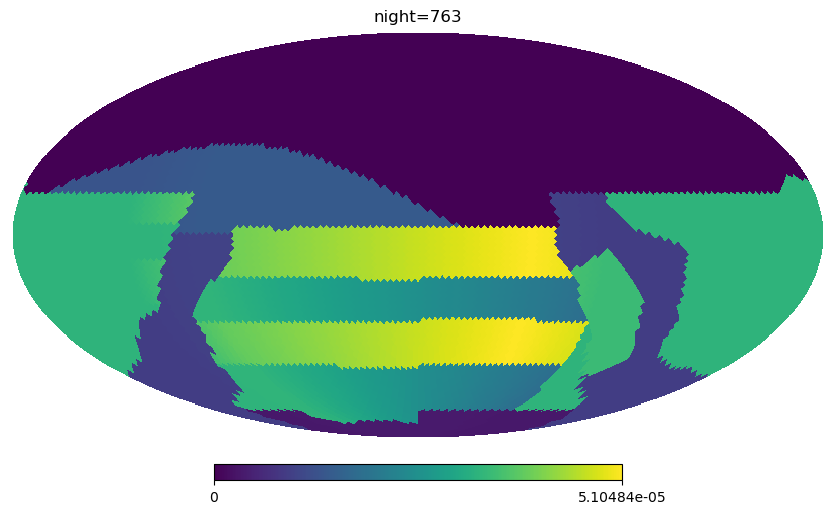

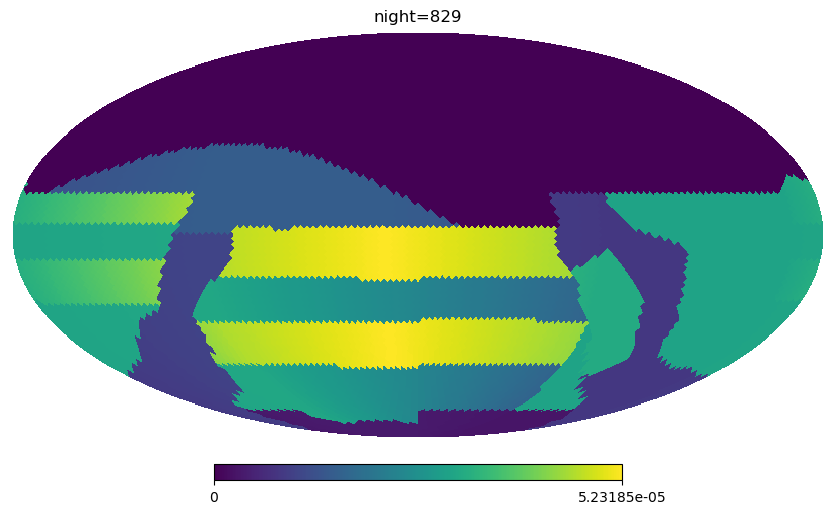

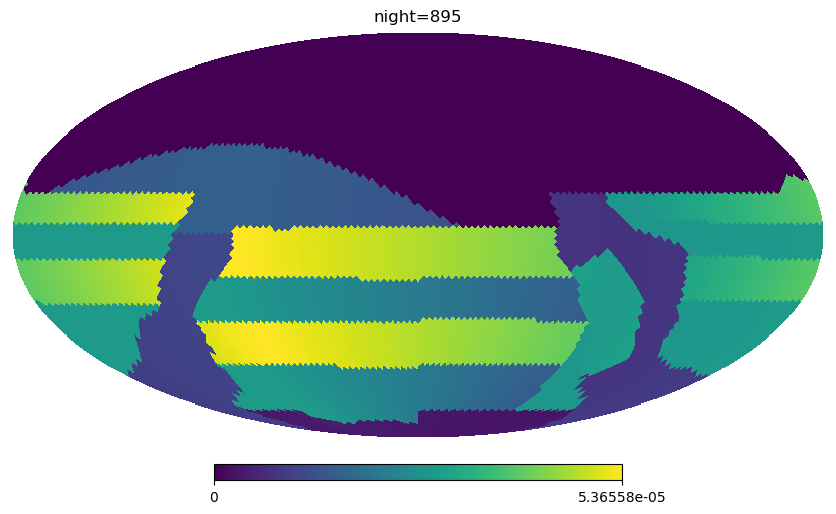

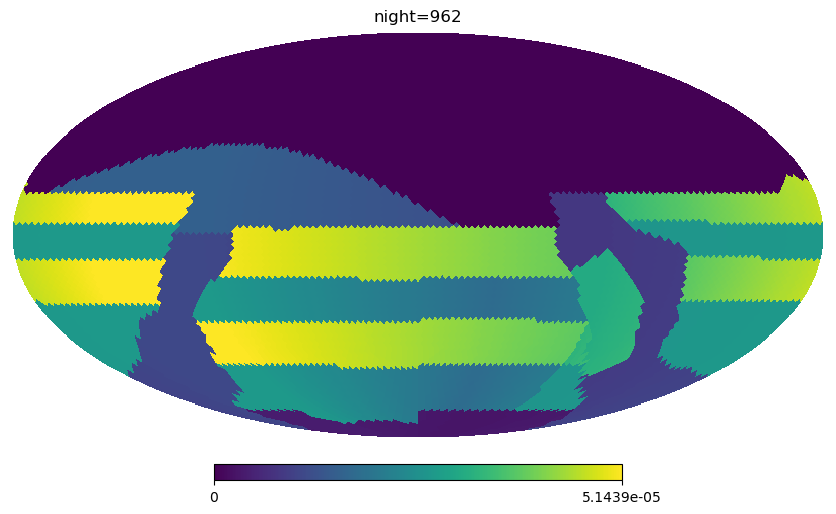

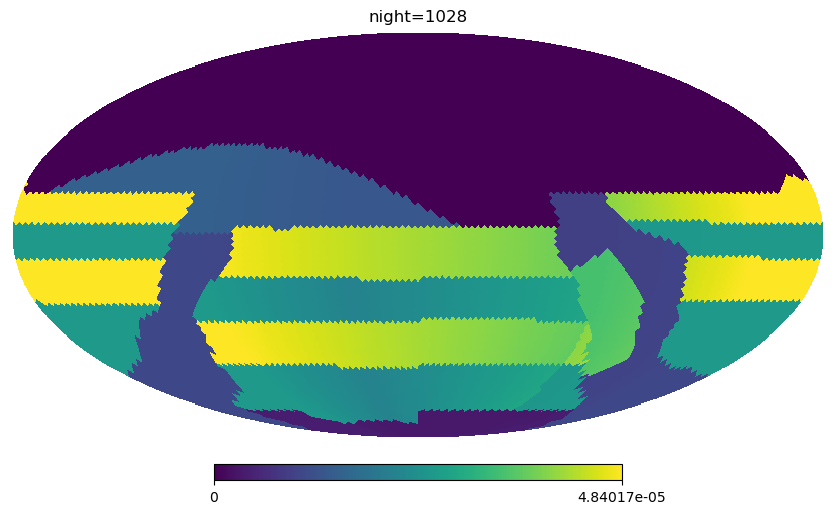

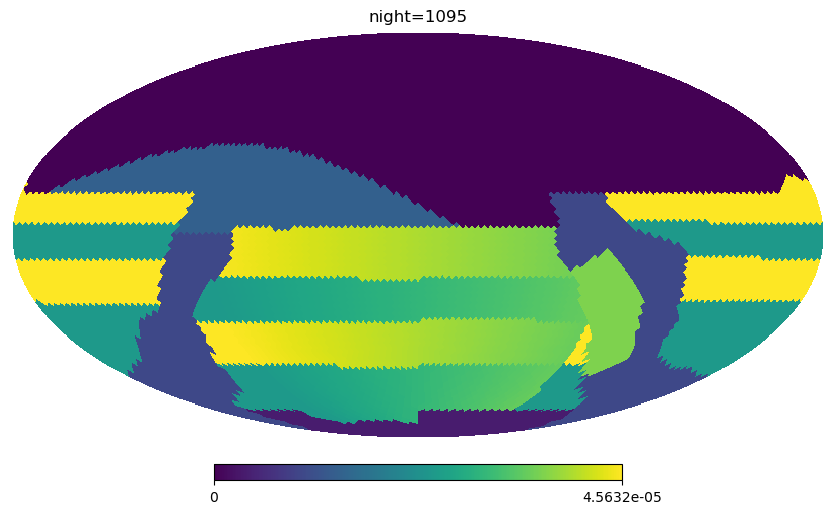

In [12]:
# Let's look at how the rolling footprints look over time

# skipping year 1 since there is no rolling. 
mjds = np.linspace(365,365*3, 12) + conditions.mjd_start

for mjd in mjds:
    fp_at_mjd = fp(mjd)
    hp.mollview(fp_at_mjd['r'], title='night=%i' % (mjd-conditions.mjd_start))

In [13]:
# Let's start out with a simple 2-band footprint where we want 1 observations in r for every 2 observations in g
blank_map = np.zeros(hp.nside2npix(nside))
indx = np.where((conditions.dec < 0) & (conditions.dec > np.radians(-20)))
simple_fp = {'r': blank_map + 0, 'g': blank_map + 0}
simple_fp['r'][indx] = 1
simple_fp['g'][indx] = 2

fp = Footprint(conditions.mjd_start, conditions.sun_ra_start)
for filtername in simple_fp:
    fp.set_footprint(filtername, simple_fp[filtername])

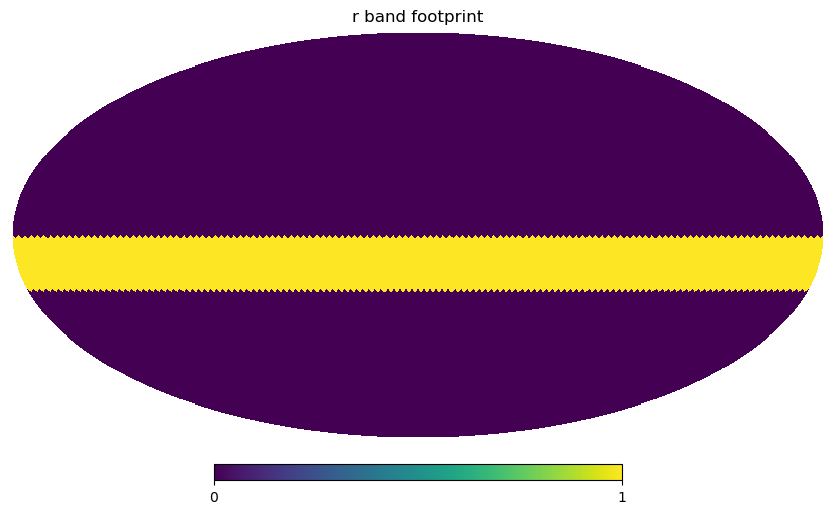

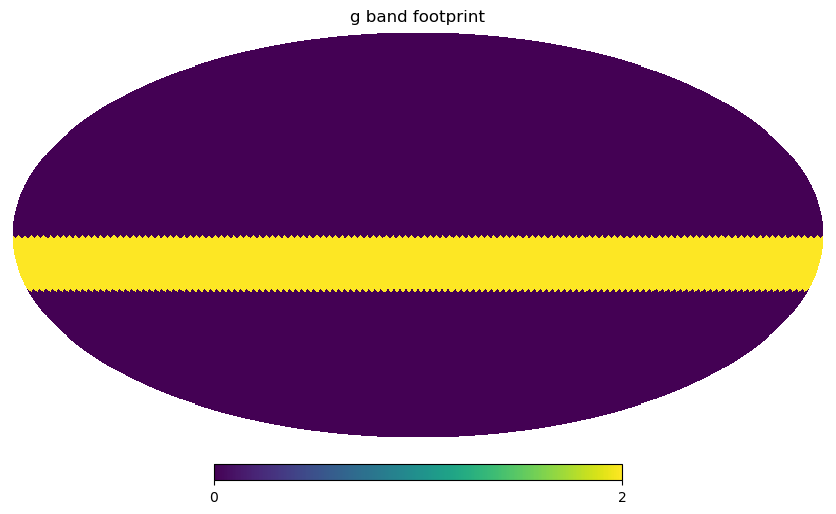

In [14]:
hp.mollview(simple_fp['r'], title='r band footprint')
hp.mollview(simple_fp['g'], title='g band footprint')


In [15]:
# Let's make two survey objects, one that will observe blobs in r, one in g
footprint_weight = 1.

red_fp_basis = bf.FootprintBasisFunction(filtername='r', footprint=fp)
red_survey = BlobSurvey([red_fp_basis], [footprint_weight], filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.FootprintBasisFunction(filtername='g', footprint=fp)
blue_survey = BlobSurvey([blue_fp_basis], [footprint_weight], filtername1='g', survey_note='g_blob')


In [16]:
scheduler = CoreScheduler([red_survey, blue_survey], nside=nside)


In [17]:
# run it for a day
try:
    mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=1.0, verbose=True)
except:
    pass

In [18]:
# this failed! Because we didn't force our survey observations to stay above the horizon. We can include the 
# 5-sigma depth basis function, since it will mask any areas that are not visible. 

footprint_weight = 1.
m5_weight = 0

red_fp_basis = bf.FootprintBasisFunction(filtername='r', footprint=fp)
m5_basis_r = bf.M5DiffBasisFunction(filtername='r', nside=nside)
red_survey = BlobSurvey([red_fp_basis, m5_basis_r],
                        [footprint_weight, m5_weight],
                        filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.FootprintBasisFunction(filtername='g', footprint=fp)
m5_basis_g = bf.M5DiffBasisFunction(filtername='g', nside=nside)
blue_survey = BlobSurvey([blue_fp_basis, m5_basis_g],
                         [footprint_weight, m5_weight],
                         filtername1='g', survey_note='g_blob')


scheduler = CoreScheduler([red_survey, blue_survey], nside=nside)


In [19]:
mo = ModelObservatory(nside=nside)

# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=7.0, verbose=True)

progress = 42.64%

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/sky_model_pre.py:272: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


progress = 99.81%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 5231 observations
ran in 0 min = 0.0 hours
Writing results to  None


In [20]:
np.unique(observations['filter'])

array(['g', 'r'], dtype='<U40')

Text(0, 0.5, 'Altitude (degrees)')

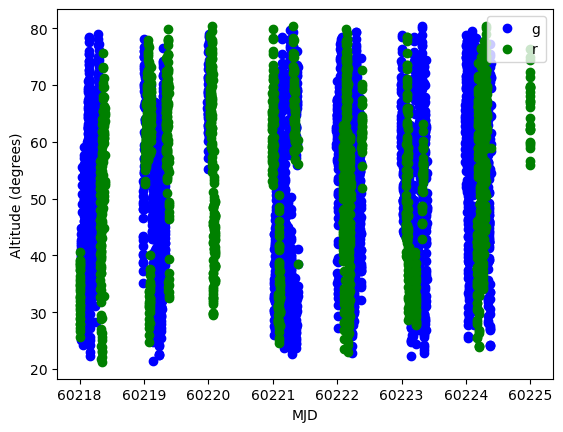

In [21]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')


Text(0, 0.5, 'Moon Altitude (degrees)')

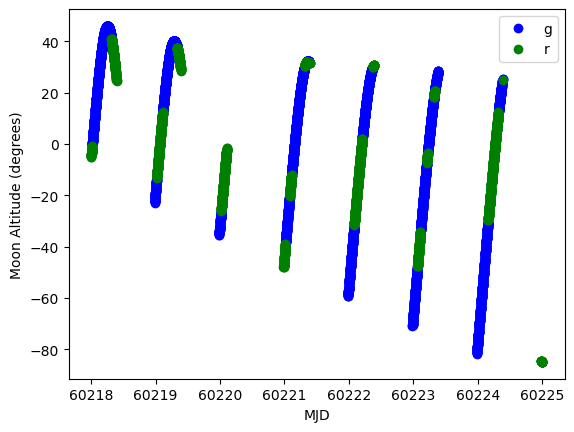

In [22]:
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['moonAlt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')

In [23]:
# ok, let's try this again, but now increase the weight on the m5 basis function
footprint_weight = 1.
m5_weight = 20

red_fp_basis = bf.FootprintBasisFunction(filtername='r', footprint=fp)
m5_basis_r = bf.M5DiffBasisFunction(filtername='r', nside=nside)
red_survey = BlobSurvey([red_fp_basis, m5_basis_r],
                        [footprint_weight, m5_weight],
                        filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.FootprintBasisFunction(filtername='g', footprint=fp)
m5_basis_g = bf.M5DiffBasisFunction(filtername='g', nside=nside)
blue_survey = BlobSurvey([blue_fp_basis, m5_basis_g],
                          [footprint_weight, m5_weight],
                          filtername1='g', survey_note='g_blob')


scheduler = CoreScheduler([red_survey, blue_survey], nside=nside)


In [24]:
mo = ModelObservatory(nside=nside)

# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=7.0, verbose=True)

progress = 99.81%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 5316 observations
ran in 0 min = 0.0 hours
Writing results to  None


Text(0, 0.5, 'Altitude (degrees)')

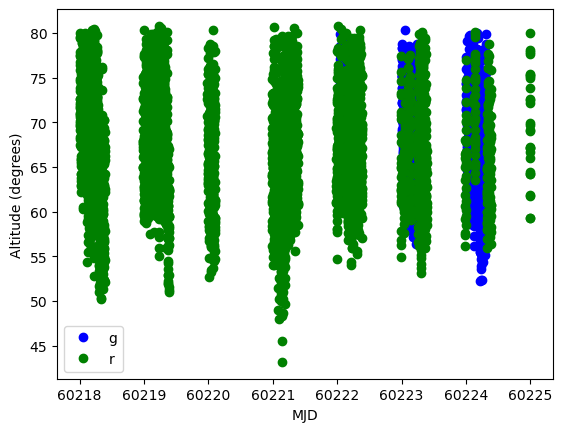

In [25]:
# let's plot and color-code by filter
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')

Text(0, 0.5, 'Moon Altitude (degrees)')

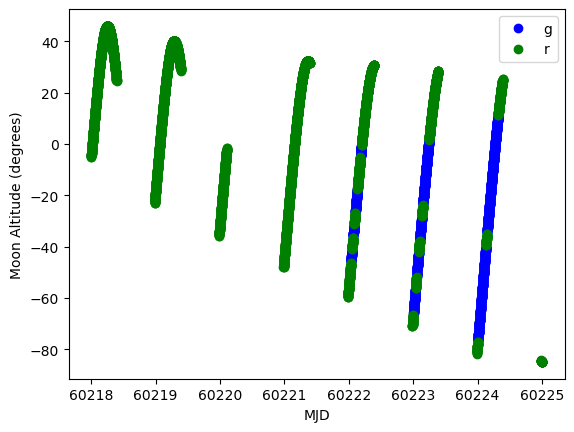

In [26]:
# let's plot and color-code by filter
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['moonAlt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')

So now we see that at the start and end of the night (twilight) and when the moon is up, the r-band survey is providing observations, then in dark time the g-band gets executed because we incerased the weight on the M5 basis function. So let's look at how the footprint basis function works

In [27]:
# We stopped mid-twilight, so let's grab the current conditions and see what the basis function looks like
conditions = mo.return_conditions()
fp_bf = scheduler.survey_lists[0][0].basis_functions[0]
fp_bf

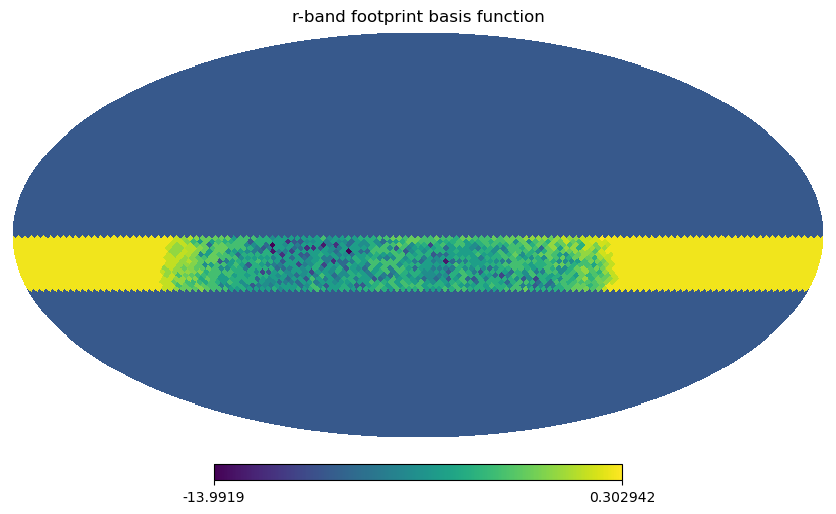

In [28]:
hp.mollview(fp_bf(conditions), title='r-band footprint basis function')

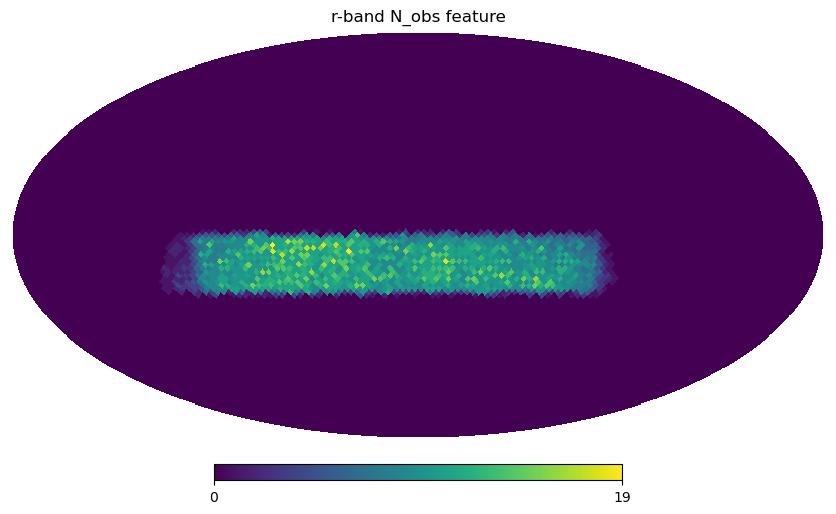

In [29]:
# The basis function holds a dict of Feature objects that track the progress of the survey
hp.mollview(fp_bf.survey_features['N_obs'](), title='r-band N_obs feature')

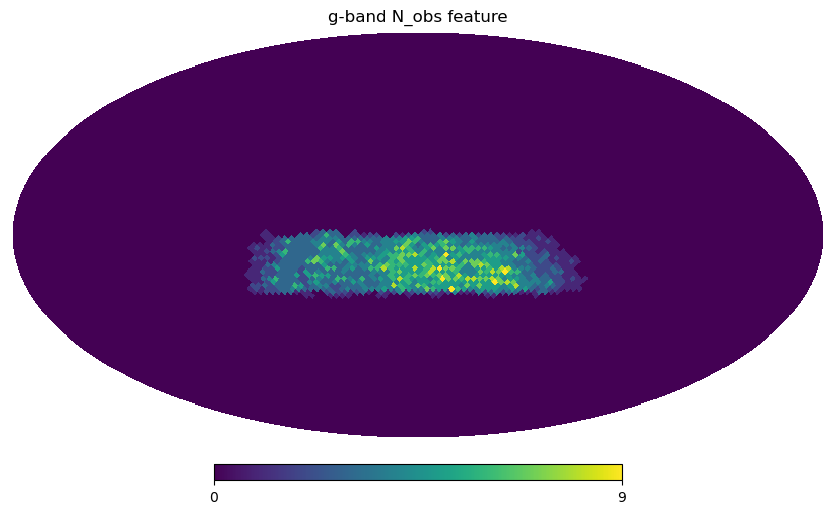

In [30]:
# And now in the g-band
hp.mollview(scheduler.survey_lists[0][1].basis_functions[0].survey_features['N_obs'](),
            title='g-band N_obs feature')

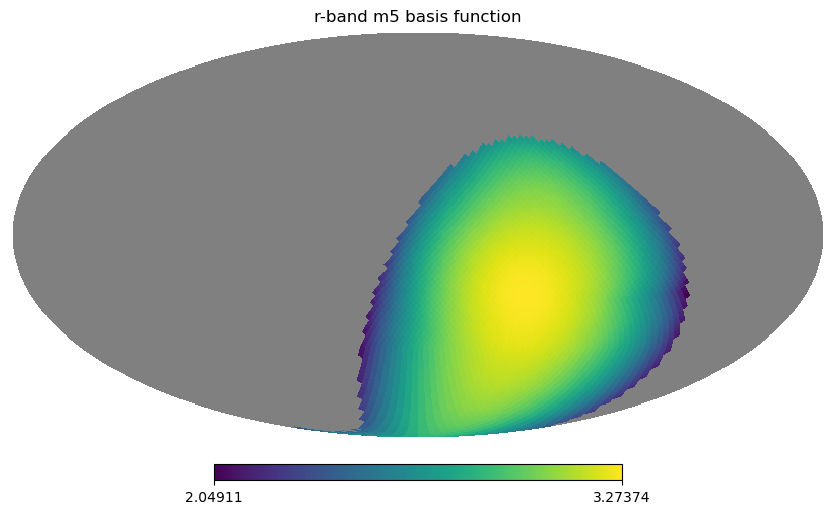

In [31]:
# Here's what the r-band m5 basis function looks like
hp.mollview(scheduler.survey_lists[0][0].basis_functions[1](conditions),
            title='r-band m5 basis function')

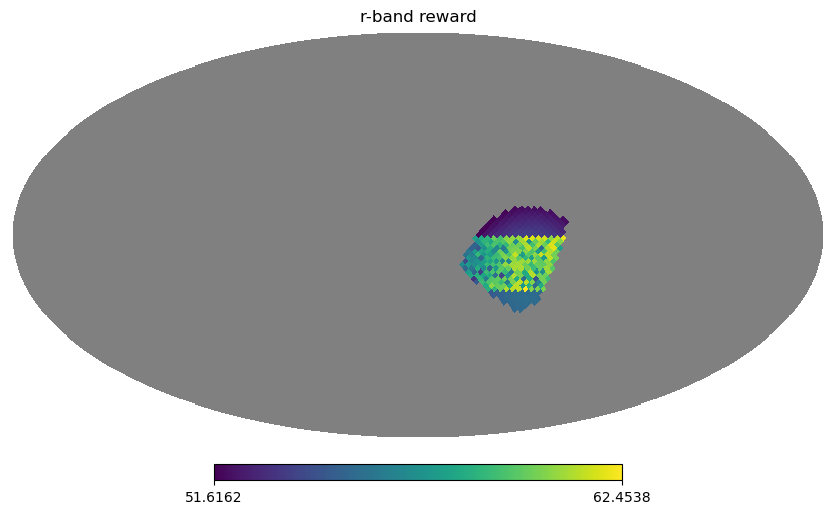

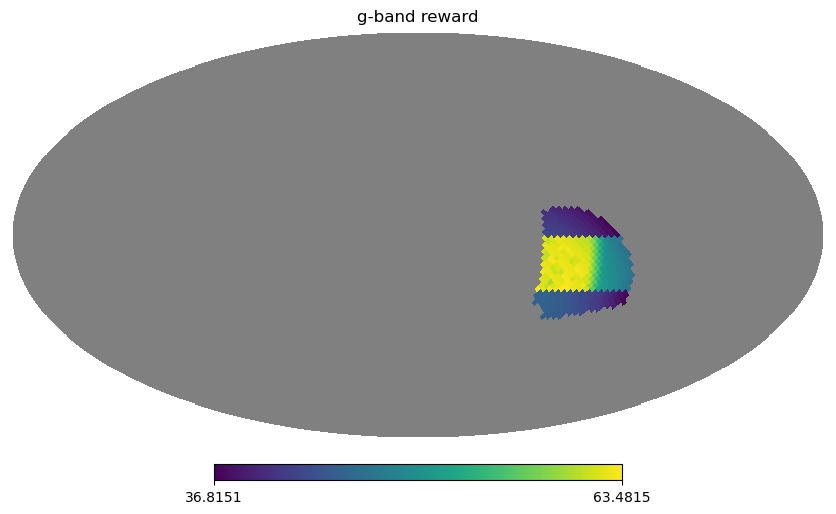

In [32]:
# The MDP survey objects have reward maps that look thusly
hp.mollview(scheduler.survey_lists[0][0].calc_reward_function(conditions), title='r-band reward')
hp.mollview(scheduler.survey_lists[0][1].calc_reward_function(conditions), title='g-band reward')


Text(0, 0.5, 'dec')

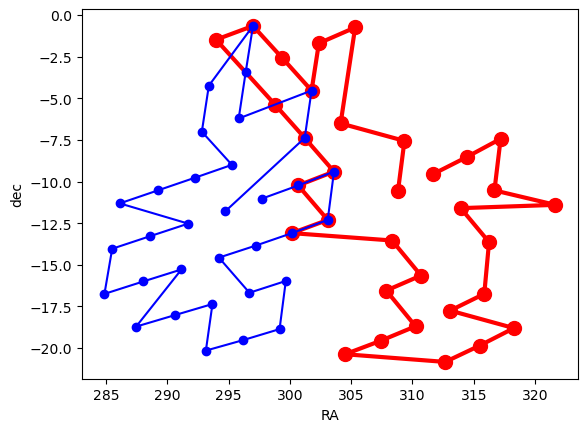

In [33]:
# We can reach into the scheduler and check what observations the survey objects
# would generate, if the scheduler decided to call them.

potential_obs_r = np.concatenate(scheduler.survey_lists[0][0].generate_observations(conditions))
potential_obs_g = np.concatenate(scheduler.survey_lists[0][1].generate_observations(conditions))
plt.plot(np.degrees(potential_obs_r['RA']), np.degrees(potential_obs_r['dec']), 'r-o', linewidth=3, markersize=10)
plt.plot(np.degrees(potential_obs_g['RA']), np.degrees(potential_obs_g['dec']), 'b-o')
plt.xlabel('RA')
plt.ylabel('dec')

So, to review the relevant objects, from the ground up

## Conditions object

From the observatory model (or the observatory), the conditions object holds information about the current state of the telescope and site. 

## Feature objects

Feature objects track the progress of the survey. They have an `add_observation` method so new observations can be added. The `__call__` method returns the value of the feature. That stored feature value can be just about anything (float, int, HEALpix array, boolean, etc). 

## Basis Function objects

Basis functions have `add_observation`, `check_feasibility`, and `__call__` methods. 

* `add_observation` passes observations on to any features the basis function uses
* `check_feasibility` checks if things are feasible. Feasibility checks are often fast and can prevent more expensive calculations from being run (no need to compute a full reward function if the feasibility is False).
* `__call__` returns the basis function reward value. This must be a HEALpix map or scalar. 

Basis functions will often have a dict of feature objects as an attribute so that feature values can be used by the methods.

There are some handy basis functions that make use of Footprint objects.

Basis functions can be used to regulate when a survey is able to execute (via the `check_feasibility` method), can be used to mask certain parts of the sky, and/or return a reward value. Generally, the reward returned by a basis function value should be of order unity.


## Survey objects

The survey objects generate lists of observations. 

* `add_observation` for passing in completed observations. These are in turn passed on to any basis functions.
* `calc_reward_function` Takes the current conditions and returns a scalar reward value. 
* `generate_observations` Takes the current conditions and returns a list of observations. 

Two main types of survey objects we use are the `BaseMarkovSurvey` and `ScriptedSurvey`. The `BaseMarkovSurvey` takes basis functions (and a weight for each function) so that it can compute a HEALpix reward map. The reward map is then used to generate a list of pointings.  `ScriptedSurvey`s take a list of desired observations and return them at the appropriate times. 

## Detailer objects

Detailer objects take a list of observations and the current conditions and return a list of observations. Useful for survey objects as they can take a list of observations and set the camera rotation for the night, or adjust the exposure times of visits, or take a list of observations in one filter and duplicate the pointings in a different filter.


## Core Scheduler

Methods:

* `add_observation` for completed observations. These get passed on to all the survey objects.
* `update_conditions` pass in the latest Conditions obejct. The core scheduler will go through and check if any survey objects have scheduled observations and add those to the conditions obejct.
* `request_observation` Returns the top observation off the queue. If there are no observations, it calls survey object reward functions until it gets a valid maximum, then uses that survey's `generate_observations` method to refill the queue.

Takes a list (or list of lists) of survey objects on initilization. This list-of-lists acts as a decision tree. If no `survey`s in the first list have a non-NaN maximum value, it moves on to the next list and so on until a `survey` has a valid maximum, then it's `generate_observations` method is called to fill the queue. 



In [34]:
# Let's say we wanted to strictly enforce that the blue blob survey should not be called when the moon is up.
# We can do this with a basis function's check_feasability method

class MoonDownBasisFunction(BaseBasisFunction):
    def __init__(self, moon_alt_limit=-5.):
        super().__init__()
        self.moon_alt_limit = np.radians(moon_alt_limit)
    def check_feasibility(self, conditions):
        result = conditions.moon_alt < self.moon_alt_limit
        return result


In [35]:
# Back to zero m5 weight, and add our new basis function to the blue_survey. My standard practice
# is to give feasability functions zero (0) weight.
footprint_weight = 1.
m5_weight = 0

red_fp_basis = bf.FootprintBasisFunction(filtername='r', footprint=fp)
m5_basis_r = bf.M5DiffBasisFunction(filtername='r', nside=nside)
red_survey = BlobSurvey([red_fp_basis, m5_basis_r],
                        [footprint_weight, m5_weight],
                        filtername1='r', survey_note='r_blob')

blue_fp_basis = bf.FootprintBasisFunction(filtername='g', footprint=fp)
m5_basis_g = bf.M5DiffBasisFunction(filtername='g', nside=nside)
moon_basis = MoonDownBasisFunction()
blue_survey = BlobSurvey([blue_fp_basis, m5_basis_g, moon_basis],
                         [footprint_weight, m5_weight, 0.],
                         filtername1='g', survey_note='g_blob')


scheduler = CoreScheduler([red_survey, blue_survey], nside=nside)


In [36]:
mo = ModelObservatory(nside=nside)
# run it for a week
mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=7.0, verbose=True)

progress = 99.81%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 5312 observations
ran in 0 min = 0.0 hours
Writing results to  None


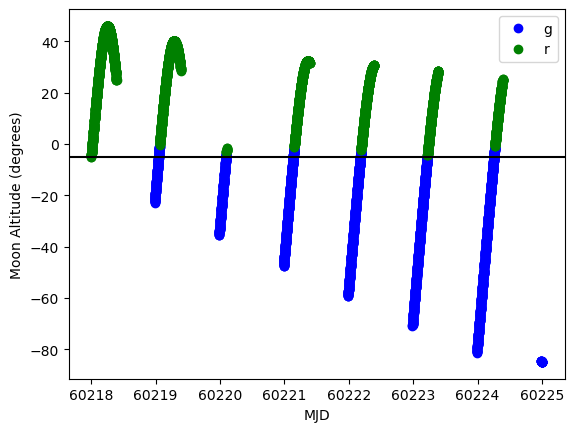

In [37]:
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['moonAlt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Moon Altitude (degrees)')
plt.axhline(-5, c='k')

In [38]:
# Note there are still a few g observations happending after the moon gets to the -5 altitude limit.
# That's because the blobs are providing ~30 observations to the queue. So, no new g-blobs happen
# before the limit, but blobs that have started are able to finish.